# DAT200 CA4 2023

Kaggle username: Tage Andersen

### Imports

In [17]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE # Important due to underrepresentation of certain target value
from sklearn.utils import shuffle

### Reading data

In [18]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.set_index("index", inplace=True)
test.set_index("index", inplace=True)

### Data exploration and visualisation

In [19]:
# Display the first few rows of the dataset
print(train.head())

# Print the summary statistics of the dataset
print(train.describe())

# Print the data types of the columns in the dataset
print(train.dtypes)

# We see three types of data: int64 and float64 which are numerical, and object which is categorical


       N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
index                                                                           
0         980      D  D-penicillamine  18713   F       N            Y       Y   
1        1455      C          Placebo  12398   F       N            Y       N   
2         216      D          Placebo  19246   F       Y            Y       Y   
3        2216      C          Placebo  19221   F       N            Y       Y   
4        1701      C  D-penicillamine  11485   F       N            N       N   

      Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos     SGOT  \
index                                                                     
0         N        6.7        561.0    5.610   154.5    1468.5  192.975   
1         N        1.3        456.0    5.280   145.5    2433.0  106.500   
2         N       24.5       1638.0    5.025   349.5    5610.0  220.875   
3         N        0.7        201.6    3.208     8.8     

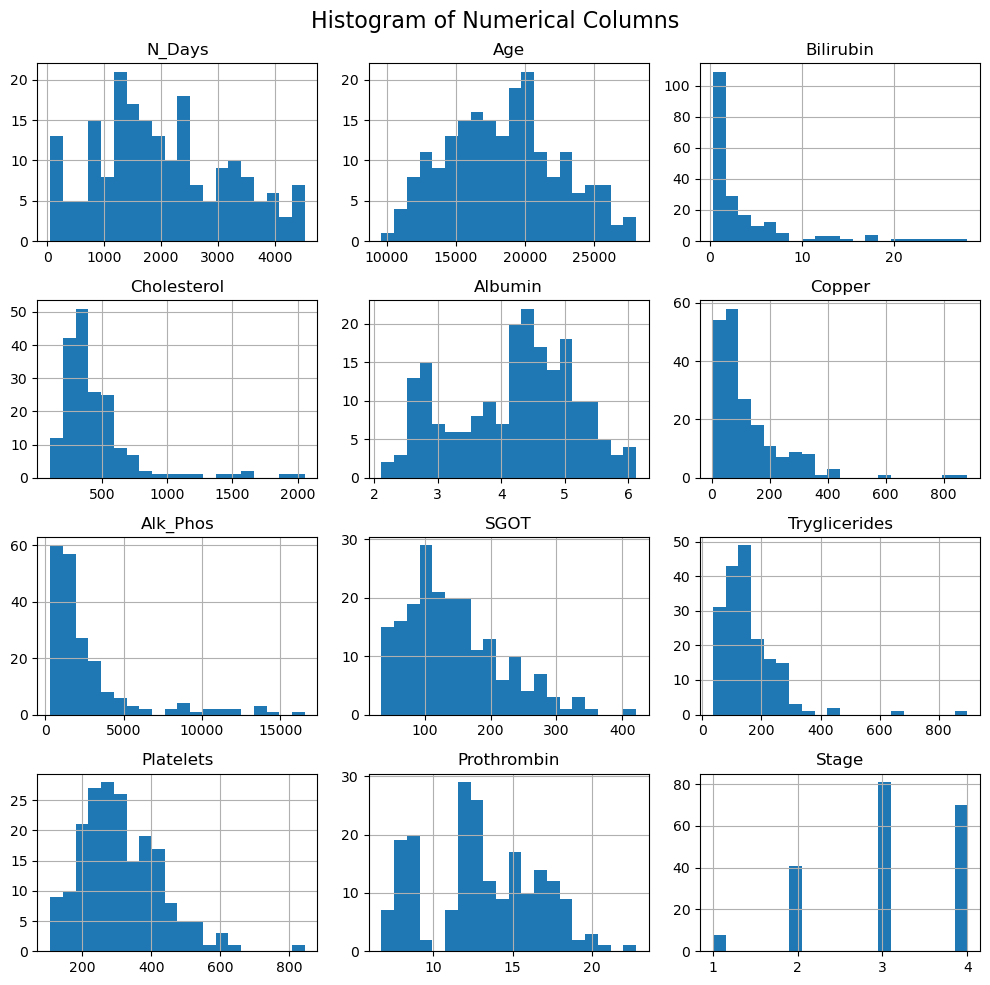

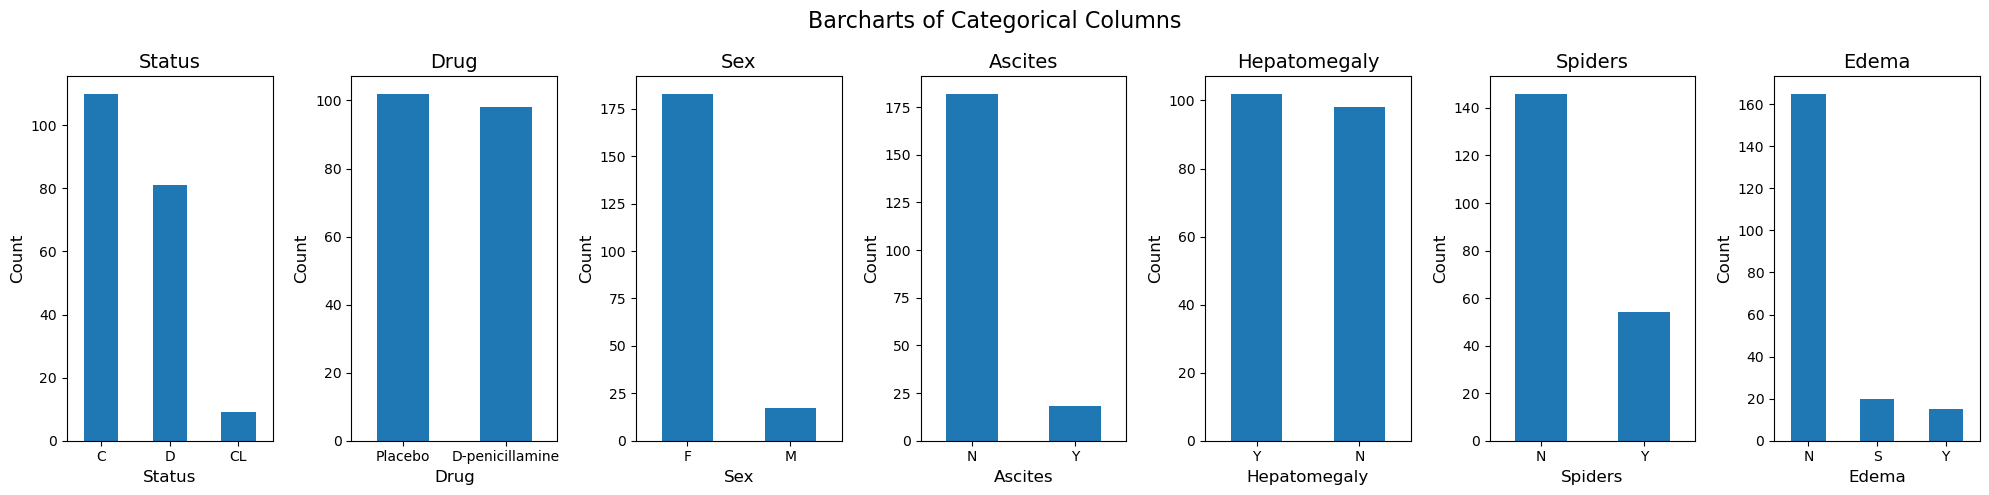

In [20]:
# Separate numerical and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train.select_dtypes(include=['object']).columns

# Plot numerical columns
train[num_cols].hist(bins=20, figsize=(10,10))
plt.suptitle("Histogram of Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()

# Plot categorical columns
fig, axs = plt.subplots(nrows=1, ncols=len(cat_cols), figsize=(20, 5))
for i, col in enumerate(cat_cols):
    train[col].value_counts().plot.bar(ax=axs[i], rot=0)
    axs[i].set_xlabel(col, fontsize=12)
    axs[i].set_ylabel("Count", fontsize=12)
    axs[i].set_title(f"{col}", fontsize=14)
plt.suptitle("Barcharts of Categorical Columns", fontsize=16)
plt.tight_layout()
plt.show()

# Spring Cleaning

### Imputing

In [21]:
# Check for columns containing nan-values
nan_cols = train.columns[train.isna().any()].tolist()

# Create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='median')

# Fill in missing values with the median value of each column containing nan_values
for col in nan_cols:
    train[col] = imputer.fit_transform(train[[col]])
    test[col] = imputer.fit_transform(test[[col]])

### Feature encoding

In [22]:
# Create an instance of the LabelEncoder class
encoder = LabelEncoder()

# Convert the 'color' column to numerical values
for col in ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.fit_transform(test[col])

After turning the dataset into a purely numerical dataset I moved on to shuffling and splitting. I also applied SMOTE due to the severe underrepresentation of one target value. After this, the training set was scaled.

In [23]:
# Shuffle the rows of the dataframe
train_shuffled = shuffle(train, random_state=1)

# Separating features and target variable
X = train_shuffled.iloc[:, :-1]
y = train_shuffled.iloc[:, -1]

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Apply SMOTE to the training set only
sm = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Create a scaler object
scaler = StandardScaler()
    
# Fit the scaler object on the training data
X_train_sc = scaler.fit_transform(X_train_resampled)

# Transform the training and test data using the scaler object
X_train_normalized = pd.DataFrame(scaler.transform(X_train_resampled))

# Plotting after cleaning and scaling

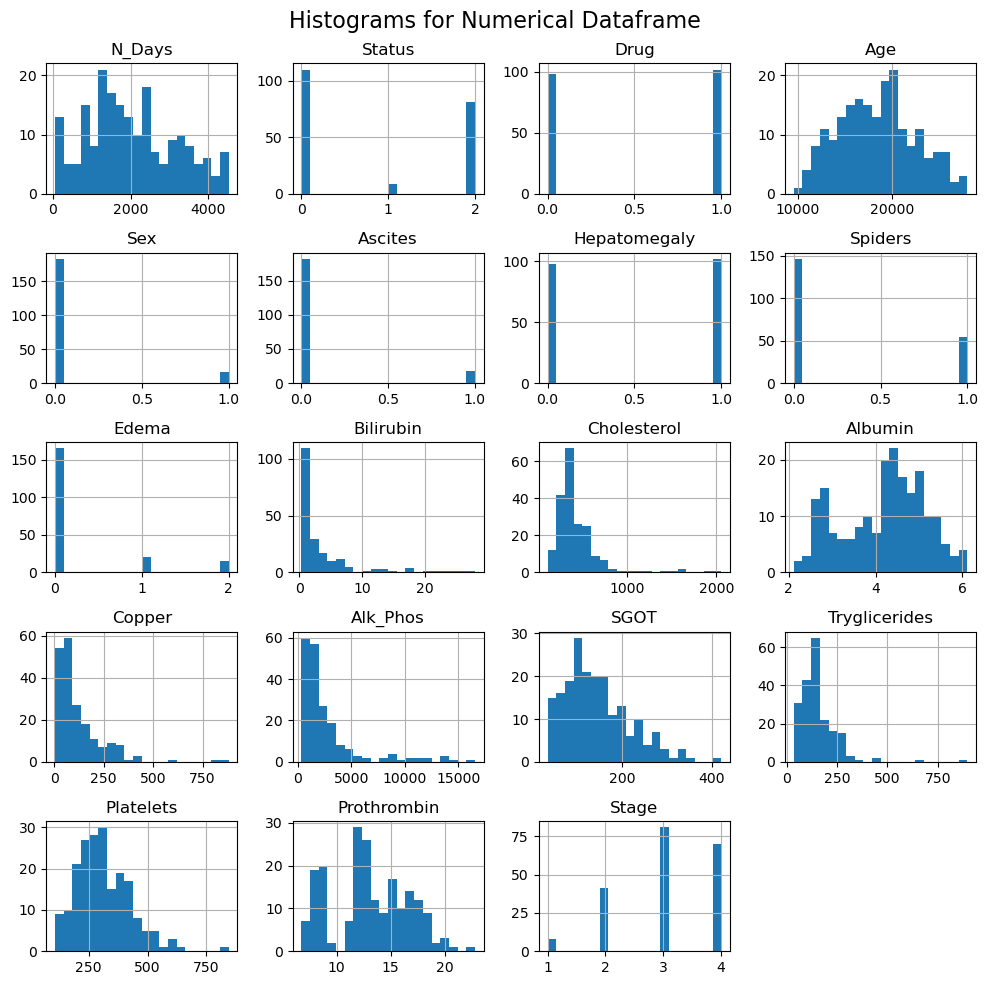

In [24]:
# Plot numerical columns
train.hist(bins=20, figsize=(10,10))
plt.suptitle("Histograms for Numerical Dataframe", fontsize=16)
plt.tight_layout()
plt.show()

# Generating pipelines

In [25]:
# pipeline with kernel classifier
kernel_pipeline = make_pipeline(StandardScaler(), SVC())

# pipeline with regularization classifier
regularization_pipeline = make_pipeline(StandardScaler(), LogisticRegression())

kernel_parameters = {
    'svc__kernel': ['linear', 'rbf', 'poly'], # Kernel types
    'svc__C': [0.1, 1, 10, 100] # Penalty parameter
}

regularization_parameters = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear']
}

#### Grid search for kernel hyperparameters

In [26]:
kernel_search = GridSearchCV(kernel_pipeline, kernel_parameters, cv=5)
kernel_search.fit(X_train, y_train)

y_pred = kernel_search.predict(X_test)
accuracy_kernel = accuracy_score(y_test, y_pred)

#### Randomized search for regularization hyperparameters

In [27]:
regularization_search = RandomizedSearchCV(regularization_pipeline, regularization_parameters, cv=5)
regularization_search.fit(X_train, y_train)

y_pred = regularization_search.predict(X_test)
accuracy_regularization = accuracy_score(y_test, y_pred)

C:\Users\SkySl\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


#### Retraining kernel pipeline with best hyperparameters

In [28]:
# generate confusion matrix for kernel pipeline
kernel_pipeline.set_params(**kernel_search.best_params_)
kernel_pipeline.fit(X_train_resampled, y_train_resampled)
y_train_pred = kernel_pipeline.predict(X_train)
confusion_kernel = confusion_matrix(y_train, y_train_pred)

#### Retraining regularization pipeline with best hyperparameters

In [29]:
# generate confusion matrix for regularization pipeline
regularization_pipeline.set_params(**regularization_search.best_params_)
regularization_pipeline.fit(X_train_resampled, y_train_resampled)
y_train_pred = regularization_pipeline.predict(X_train)
confusion_regularization = confusion_matrix(y_train, y_train_pred)

## Confusion matrices

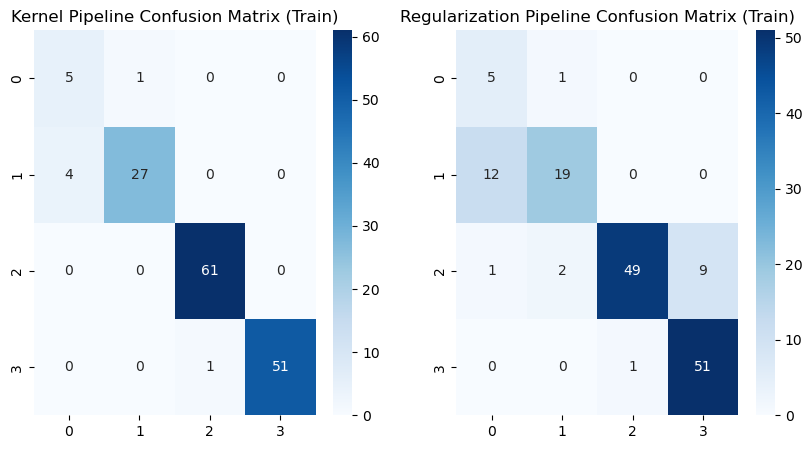

In [30]:
# plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.heatmap(confusion_kernel, annot=True, cmap='Blues', ax=axes[0])
sns.heatmap(confusion_regularization, annot=True, cmap='Blues', ax=axes[1])
axes[0].set_title('Kernel Pipeline Confusion Matrix (Train)')
axes[1].set_title('Regularization Pipeline Confusion Matrix (Train)')
plt.show()

# Kaggle submission

In [31]:
# make predictions on test data using the retrained pipelines
y_pred_kernel = kernel_pipeline.predict(test)
y_pred_regularization = regularization_pipeline.predict(test)

# create a new dataframe to store the predictions
results_kernel = pd.DataFrame({'Stage': y_pred_kernel})
results_regularization = pd.DataFrame({'Stage': y_pred_regularization})

# save the predictions to a CSV file
results_kernel.to_csv('results_kernel.csv', index=False)
results_regularization.to_csv('results_regularization.csv', index=False)

kaggle_kernel = pd.read_csv('results_kernel.csv', sep=',')
#kaggle_kernel.set_index("index", inplace=True) # Setting the "id" column as the index column
kaggle_regularization = pd.read_csv('results_regularization.csv', sep=',')
#kaggle_regularization.set_index("index", inplace=True)
print("Kernel results\n", kaggle_kernel, "\n")
print("Regularization results\n", kaggle_regularization)

Kernel results
      Stage
0        3
1        4
2        3
3        1
4        3
..     ...
104      4
105      4
106      2
107      4
108      2

[109 rows x 1 columns] 

Regularization results
      Stage
0        3
1        4
2        3
3        2
4        3
..     ...
104      4
105      4
106      2
107      4
108      2

[109 rows x 1 columns]
